In [1]:
## Expand JVM memory
options(java.parameters = "-Xmx8000m")

## Internal helpers
source("../R/helpers.R")

## Climate4R
library(loadeR)
library(visualizeR)
library(fireDanger)
library(convertR)

Loading required package: transformeR




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

Loading required package: rJava

Loading required package: loadeR.java

Java version 11x amd64 by Azul Systems, Inc. detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded


Get the latest stable version (1.8.2) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>

Please use 'citation("loadeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.

fireDanger version 1.2.0 (2025-04-15) is loaded

Type <vignette("Climate_Services_2017",

In [2]:
data.dir <- "/mnt//CORDEX_CMIP6_tmp//sim_data//CORDEX-CMIP6//DD//EUR-12//"

In [3]:
years <- 1980:2005

In [4]:
lf <- list.files("../data_catalogs/", full.names = TRUE)

In [5]:
(models <- availableModels())

[1] "CCLM6-0-1-URB"       "ICON-CLM-202407-1-1"

In [6]:
dataset <- lf[1]

## Loading variables and unit conversion

Variables are loaded pointing to their corresponding NcML catalogues (see `1_data_catalogs.ipynb`). Note that **unit conversion** is performed immediately after load, with `udConverGrid`, a wrapper of the [UDUNITS](https://www.unidata.ucar.edu/software/udunits/) Unidata library.

In [7]:
tas <- loadGridData(dataset,
                    var = "tas",
                    time = "12",
                    year = years[1],
                    season = 6:9) %>% udConvertGrid(., new.units = "degC")

[2025-04-15 19:04:40.068174] Defining geo-location parameters

[2025-04-15 19:04:40.240356] Defining time selection parameters

[2025-04-15 19:04:42.25879] Retrieving data subset ...

[2025-04-15 19:04:45.196674] Done



[2025-04-15 19:04:49.226318] - Computing climatology...

[2025-04-15 19:04:50.561046] - Done.



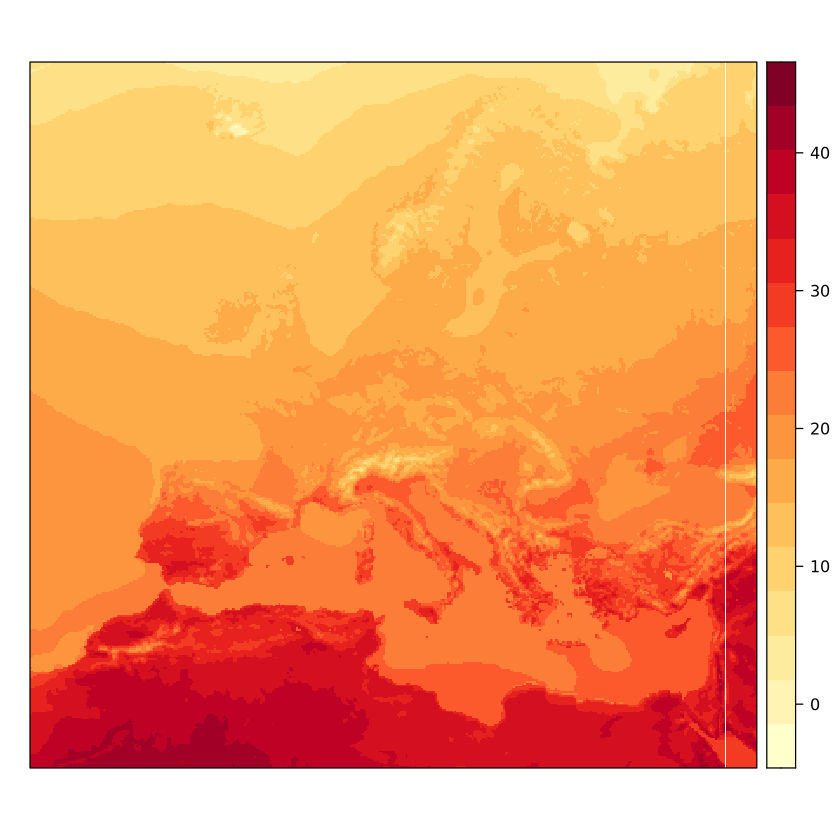

In [8]:
spatialPlot(climatology(tas), color.theme = "YlOrRd")

In [9]:
wss <- loadGridData(dataset,
                    var = "sfcWind",
                    time = "12",
                    year = years[1],
                    season = 6:9) %>% udConvertGrid(., new.units = "km.h-1")

[2025-04-15 19:04:51.676739] Defining geo-location parameters

[2025-04-15 19:04:51.801668] Defining time selection parameters

[2025-04-15 19:04:53.272615] Retrieving data subset ...

[2025-04-15 19:04:55.980632] Done



[2025-04-15 19:04:59.027629] - Computing climatology...

[2025-04-15 19:05:00.457124] - Done.



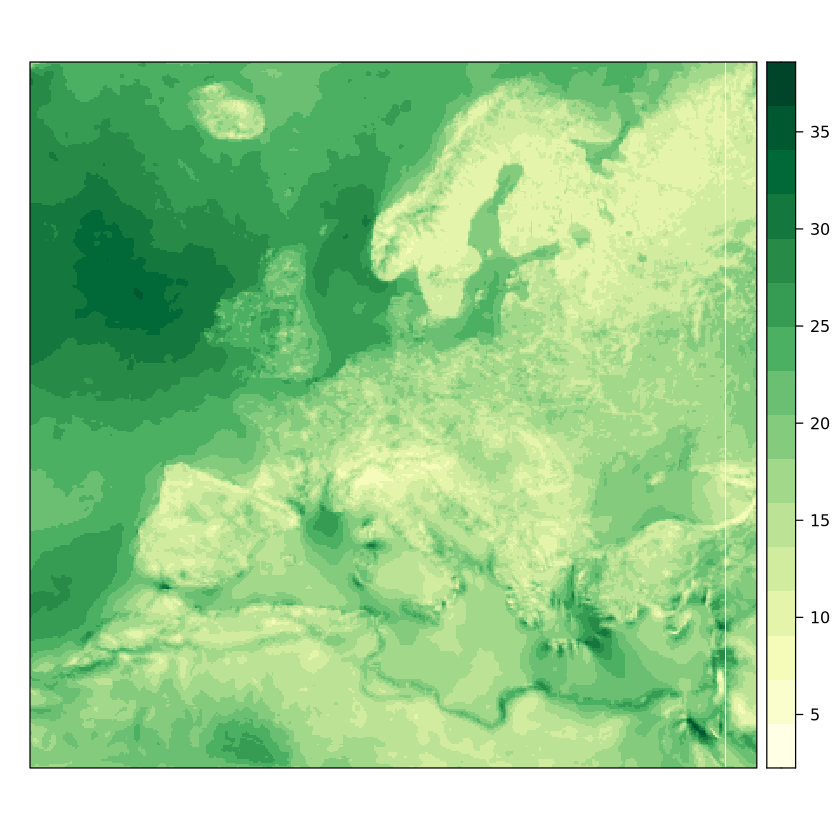

In [10]:
spatialPlot(climatology(wss), color.theme = "YlGn")

In [11]:
hurs <- loadGridData(dataset,
                     var = "hurs",
                     time = "12",
                     year = years[1],
                     season = 6:9) %>% udConvertGrid(., new.units = "%")

[2025-04-15 19:05:01.390126] Defining geo-location parameters

[2025-04-15 19:05:01.527521] Defining time selection parameters

[2025-04-15 19:05:02.865114] Retrieving data subset ...

[2025-04-15 19:05:05.018476] Done



[2025-04-15 19:05:08.940794] - Computing climatology...

[2025-04-15 19:05:10.177876] - Done.



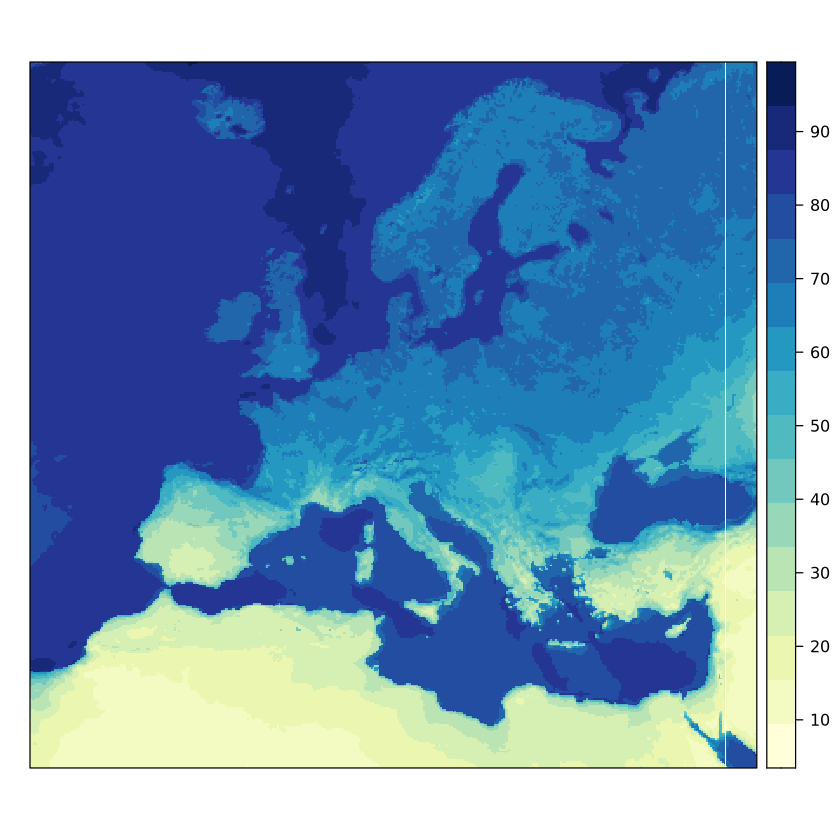

In [12]:
spatialPlot(climatology(hurs), color.theme = "YlGnBu")

### Precipitation
Precipitation is read from a temporary directory, where daily accumulated precipitation from 12UTC to 12UTC is stored as an intermediate, FWI-specific product (see `R/accum_tp.R` script). It is already in mm, so no unit conversion is required.

In [13]:
pr.dataset <- "../data_catalogs/CCLM6-0-1-URB_pr12.ncml"

In [14]:
tp <- loadGridData(pr.dataset,
                   var = "pr",
                   year = years[1],
                   season = 6:9)

[2025-04-15 19:05:10.854817] Defining geo-location parameters

[2025-04-15 19:05:10.986165] Defining time selection parameters

[2025-04-15 19:05:11.027295] Retrieving data subset ...

[2025-04-15 19:05:13.542632] Done



In [15]:
# tp$Variable$varName <- "tp"

[2025-04-15 19:05:13.70195] - Computing climatology...

[2025-04-15 19:05:15.121545] - Done.



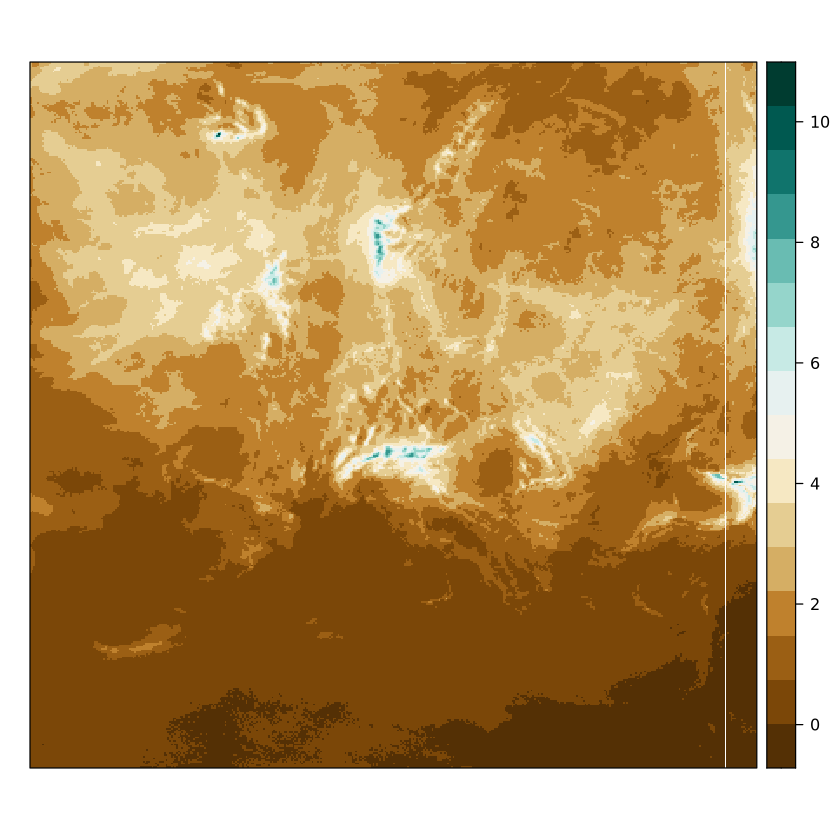

In [16]:
spatialPlot(climatology(tp), color.theme = "BrBG")

## Multigrid

The multigrid is a "stack" of the four input variables. It ensures spatio-temporal consistency prior to FWI calculation.

In [17]:
mg <- makeMultiGrid(tas, hurs, wss, tp)

In [18]:
tas <- hurs <- wss <- tp <- NULL
gc()
# save(mg, lm.bin,  file = "../test_fwi.Rdata")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1665228,89.0,4489612,239.8,4489612,239.8
Vcells,88543741,675.6,405675830,3095.1,503753441,3843.4


## Landmask

The landmask will prevent pointless calculations on the sea, saving time and potential errors


In [19]:
landmask <- list.files(path = "/mnt/CORDEX_CMIP6_tmp/sim_data/CORDEX-CMIP6/DD/EUR-12/CLMcom-CMCC/ERA5/evaluation/r1i1p1f1/CCLM6-0-1-URB/v1-r1/fx/",
                       pattern = "^sftlf.*nc$",
                       recursive = TRUE,
                       full.names = TRUE)

In [20]:
lm <- loadGridData(dataset = landmask, var = "sftlf")

[2025-04-15 19:05:27.890809] Defining geo-location parameters

[2025-04-15 19:05:27.955169] Defining time selection parameters

NOTE: Undefined Dataset Time Axis (static variable)

[2025-04-15 19:05:27.959812] Retrieving data subset ...

[2025-04-15 19:05:28.011773] Done



As the landmask is in essence a binary matrix telling the function where to compute FWI and where not, we set a land area fraction threshold (here 0.5) below which we consider the entire pixel as "sea":

In [21]:
lm.bin <- binaryGrid(lm, condition = "GE", threshold = .5)

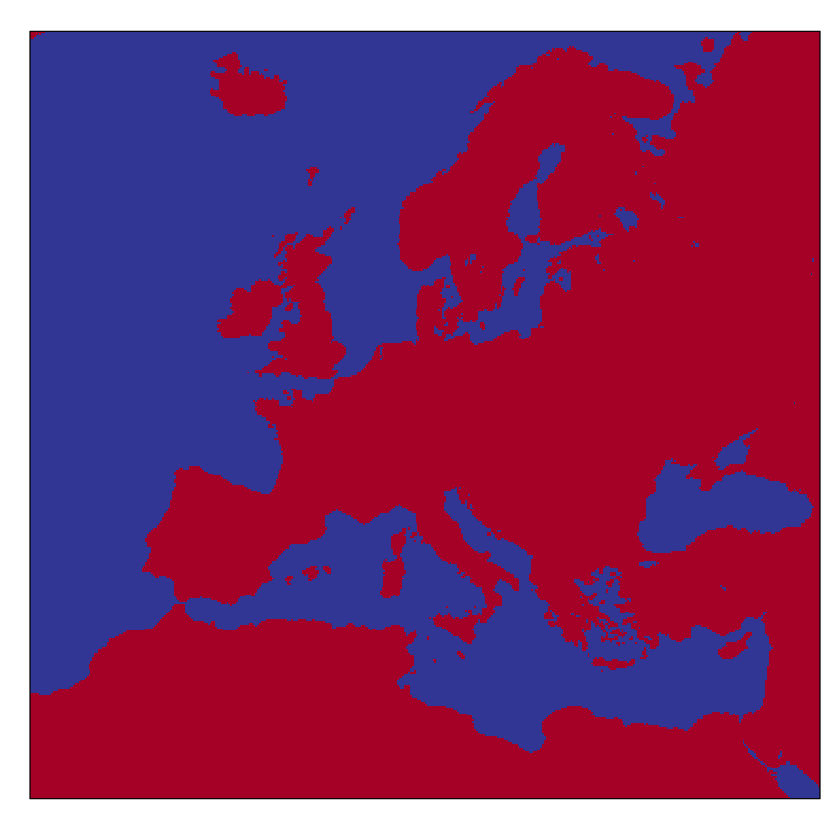

In [22]:
spatialPlot(lm.bin, colorkey = FALSE, rev.colors = TRUE)

## FWI Calculation
The argument `what` can be set to other FWI components (`DC`, `FFMC`, `BUI`, etc.). The default is `"FWI"`, but we indicate it here anyway for clarity. The inclusion of the mask will ensure that land-only pixels are computed.

In [34]:
test <- fwiGrid(mg, mask = lm.bin, what = "FWI") 

[2025-04-15 19:26:10.836671] Calculating FWI

[2025-04-15 19:27:08.279742] Done.



### Plotting FWI90

In [25]:
clim <- climatology(test)

[2025-04-15 19:06:41.328514] - Computing climatology...

[2025-04-15 19:06:42.489547] - Done.



Resulting mean FWI climatology:

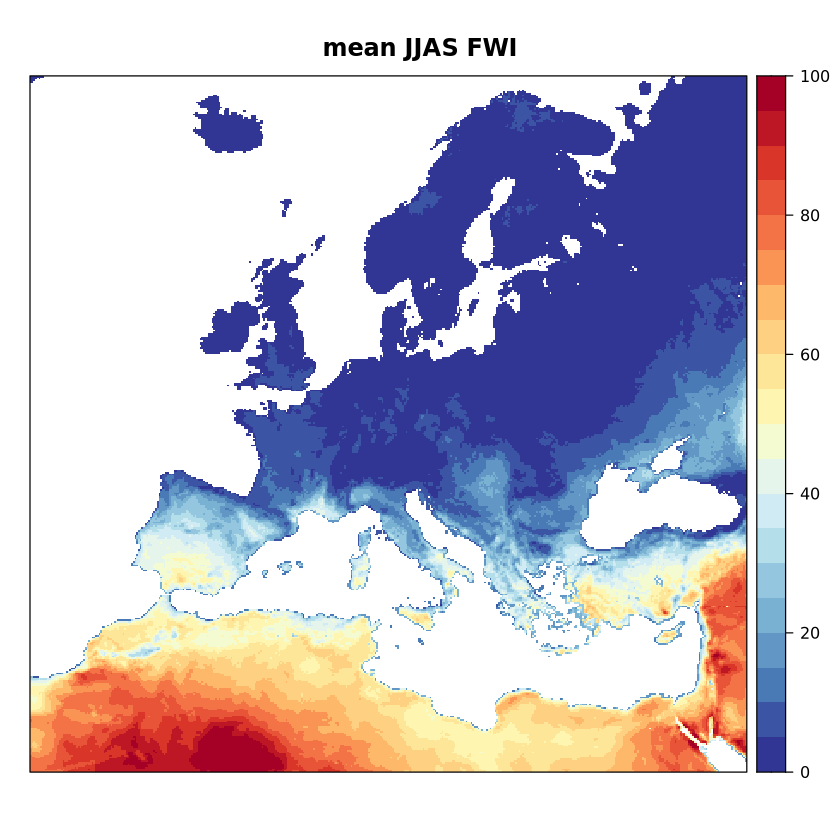

In [28]:
spatialPlot(clim, main = "mean JJAS FWI", rev.colors = TRUE, at = seq(0,100,5), set.max = 100)

A time series of the spatially averaged FWI:

pad applied on the interval: day



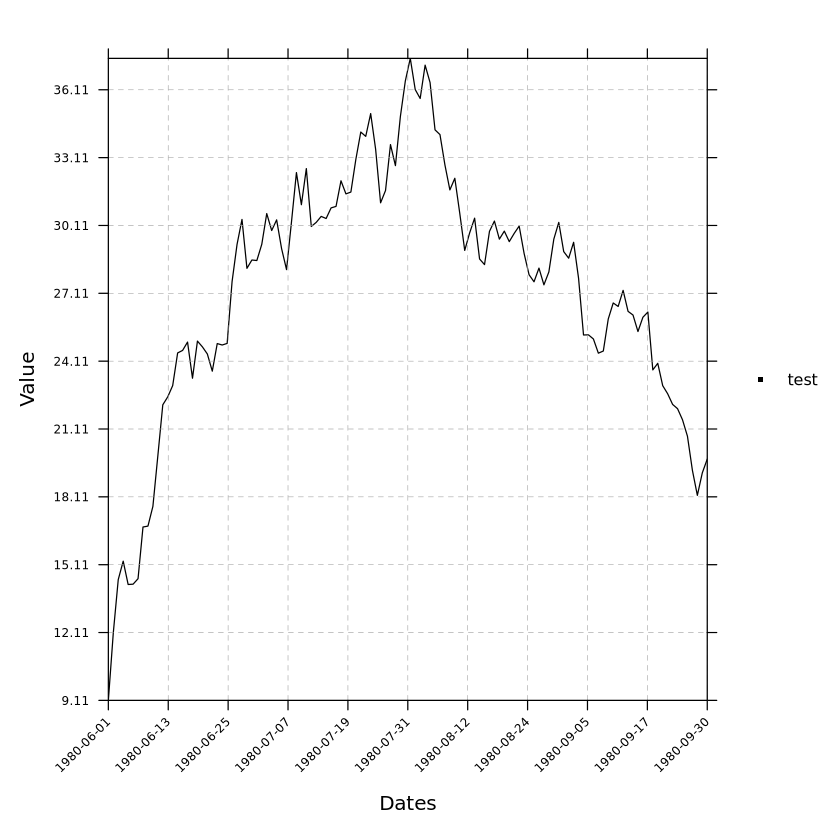

In [36]:
temporalPlot(test)

In [19]:
help("fwiGrid")

fwiGrid {fireDanger},R Documentation
multigrid,containing Tm (temperature records in deg. Celsius); H (relative humidity records in %); r (last 24-h accumulated precipitation in mm); W (wind velocity records in Km/h). See details.
mask,"Optional. Binary grid (0 and 1, 0 for sea areas) with dimensions attribute c(""lat"", ""lon"")."
what,"Character string. What component of the FWI system is computed?. Default to ""FWI"". Note that unlike fwi1D, only one single component choice is possible in fwiGrid. See fwi1D for details and possible values."
nlat.chunks,"For an efficient memory usage, the computation of FWI can be split into latitudinal bands (chunks) sepparately. The number of chunks is controlled here. Default to NULL (i.e., no chunking applied)."
restart.annual,"Logical. Should the calculation be restarted at the beginning of every year? If the grid encompasses just one season (e.g. JJA...), this is the recommended option. Default to TRUE."
parallel,Logical. Should parallel execution be used?
ncores,"Integer number of cores used in parallel computation. Self-selected number of cores is used when ncpus = NULL (the default), or when maxcores exceeds the default ncores value."
max.ncores,Integer. Upper bound for user-defined number of cores.
...,Further arguments passed to fwi1D.


In [23]:
help("fwi1D")

fwi1D {fireDanger},R Documentation
months,Vector of integers corresponding to the months in the data
Tm,Vector of temperature records (deg. Celsius)
H,Vector of relative humidity records (%)
r,Vector of last 24-h accumulated precipitation (mm)
W,Vector of wind velocity records (Km/h)
lat,"Optional. Latitude of the records (in decimal degrees). Default to 46, applying the default parameters of the original FWI System, developed in Canada. See Daylength Adjustment details."
what,"Character vector, indicating the components of the FWI system to be returned. Accepted values include any possible subset of the set {""FFMC"",""DMC"",""DC"" ,""BUI"",""ISI"",""FWI"",""DSR""}. Default to ""FWI""."
init.pars,"A numeric vector of length 3 with the initialization values for the FFMC, DMC and DC components, in this order. Default values as proposed by van Wagner (1987)."
spin.up,Non-negative integer indicating the number of days considered for FWI spin-up. Default to 0 (i.e. no spin-up is considered). See the dedicated Section below for further details.
